In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from fbprophet import Prophet

# Functions

In [2]:
# function to run Prophet and return the forecast
def ProphetForecast(df_input):
    m = Prophet(daily_seasonality=False, yearly_seasonality=True, 
            seasonality_mode='multiplicative', growth='logistic')
    m.fit(df_input)
    # find how many periods we need by finding the last day in the item
    days_to_predict = pd.to_datetime('2016-1-31') - df_input['ds'].max()
    future = m.make_future_dataframe(periods=days_to_predict.days)
    # in logarithmic space 10-2 is 0.01
    future['floor'] = -2
    future['cap'] = df_input['y'].max()
    forecast = m.predict(future)
    return forecast

# Load Data

In [3]:
df_sales = pd.read_csv('../data/sales_train_v2.csv')

#  Data Cleaning

In [4]:
# make date-time format use day first
df_sales['date'] = pd.to_datetime(df_sales['date'],  dayfirst=True)

In [5]:
# remove 0 or negative item count
df_sales = df_sales.loc[df_sales['item_cnt_day']>0]

In [6]:
# Replace negative price with mean
mean = int(df_sales.loc[df_sales['item_id']==2973, 'item_price'].mean())
df_sales["item_price"] = df_sales["item_price"].mask(df_sales["item_price"] <0, mean)

INFO:numexpr.utils:NumExpr defaulting to 1 threads.


In [7]:
# Get sales data only for items had sales after 2015-05-01
df_sales_recent = df_sales[df_sales.date > '2015-05-01']
df_item1 = df_sales_recent.drop(['date', 'date_block_num','shop_id','item_price','item_cnt_day'], axis=1)
df_item2=df_item1.drop_duplicates()

In [8]:
df_sales_recent_6m = pd.merge(left=df_item2,right=df_sales, how='left', on='item_id')

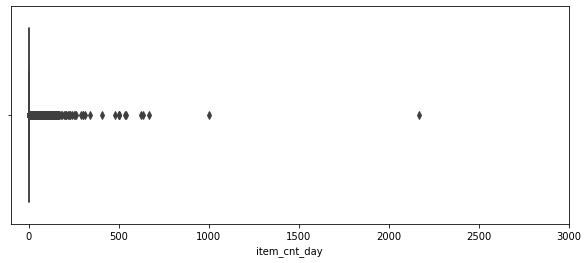

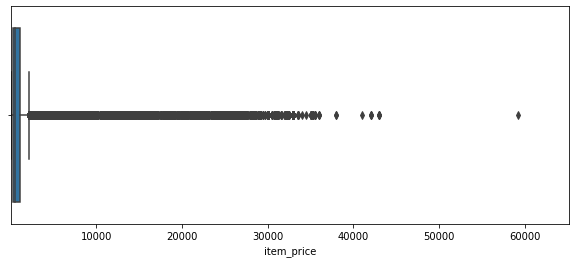

In [9]:
# Outlier exploration
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=df_sales_recent_6m.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(df_sales_recent_6m.item_price.min(), df_sales_recent_6m.item_price.max()*1.1)
sns.boxplot(x=df_sales_recent_6m.item_price)

In [10]:
# Remove outliers on Price
# Sales data for all items that have sales in the last 6 months
df_sales_clean_all_items = df_sales_recent_6m[df_sales_recent_6m.item_price<40000]
df_sales_clean_all_items

,item_id,date,date_block_num,shop_id,item_price,item_cnt_day
0,15710,2013-04-30,3,25,349.0,1.0
1,15710,2013-04-27,3,25,349.0,4.0
2,15710,2013-04-26,3,25,349.0,1.0
3,15710,2013-04-25,3,25,349.0,2.0
4,15710,2013-04-27,3,21,349.0,1.0
...,...,...,...,...,...,...
2112327,7610,2015-10-29,33,25,2890.0,1.0
2112328,7635,2015-10-22,33,25,2100.0,1.0
2112329,7638,2015-01-18,24,25,1660.0,1.0
2112330,7638,2015-10-30,33,25,1890.0,1.0


# Create dataframe of most sold items

In [11]:
# find the most sold items
df_sales_totalitem = df_sales_clean_all_items.groupby(['item_id'])['item_cnt_day'].sum().reset_index(name='item_cnt_total')
df_sales_totalitem = df_sales_totalitem.sort_values(by='item_cnt_total',ascending=False)
df_sales_totalitem.head(10)

,item_id,item_cnt_total
8373,20949,187660.0
1128,2808,17255.0
1547,3732,16676.0
7125,17717,15830.0
2423,5822,14522.0
1549,3734,11733.0
2733,6675,10315.0
1546,3731,10105.0
754,1855,10041.0
6815,16787,9255.0


# Loop starts here

In [12]:
# rename columns
df_sales_clean_all_items = df_sales_clean_all_items.rename(columns={"date": "ds"})
# create a submission dataframe
submission = pd.DataFrame([], columns=['item_id', 'item_cnt_month'])
submission

,item_id,item_cnt_month


In [13]:

# iterate through top 10
number_of_items_to_predict = 10
for index, row in df_sales_totalitem.head(number_of_items_to_predict).iterrows():
    # create df for prophet
    df_fbprophet = df_sales_clean_all_items.loc[(df_sales_clean_all_items['item_id']==row['item_id'])]
    # sum the total sold for each day for this item
    df_fbprophet = df_fbprophet.groupby(['ds'])['item_cnt_day'].sum().reset_index(name='y')

    # convert to log scale
    df_fbprophet['y'] = np.log(df_fbprophet['y'])

    # in logarithmic space 10-2 is 0.01
    df_fbprophet['floor']=-2
    df_fbprophet['cap']=df_fbprophet['y'].max()
    forecast = ProphetForecast(df_fbprophet)
    # forecast for the whole month of November
    item_cnt_nov2015 = np.exp(forecast.loc[(forecast['ds']>=pd.to_datetime('2015-11-1')) 
                             & (forecast['ds']<=pd.to_datetime('2015-11-30'))]['yhat']).sum()
    print('item_id: ' + str(row['item_id']) + ', total items:' + str(row['item_cnt_total']), end="")
    print(', Nov 2015 forecast: ' + str(round(item_cnt_nov2015, 1)))
    # make a new row in submission with the item_id
    submission.loc[len(submission)] = [row['item_id'], round(item_cnt_nov2015, 1)]


item_id: 20949.0, total items:187660.0, Nov 2015 forecast: 3079.4
item_id: 2808.0, total items:17255.0, Nov 2015 forecast: 40.2
item_id: 3732.0, total items:16676.0, Nov 2015 forecast: 44.6
item_id: 17717.0, total items:15830.0, Nov 2015 forecast: 732.7
item_id: 5822.0, total items:14522.0, Nov 2015 forecast: 235.0
item_id: 3734.0, total items:11733.0, Nov 2015 forecast: 45.3
item_id: 6675.0, total items:10315.0, Nov 2015 forecast: 50.1
item_id: 3731.0, total items:10105.0, Nov 2015 forecast: 50.9
item_id: 1855.0, total items:10041.0, Nov 2015 forecast: 36.8
item_id: 16787.0, total items:9255.0, Nov 2015 forecast: 24.6


In [14]:
submission

,item_id,item_cnt_month
0,20949.0,3079.4
1,2808.0,40.2
2,3732.0,44.6
3,17717.0,732.7
4,5822.0,235.0
5,3734.0,45.3
6,6675.0,50.1
7,3731.0,50.9
8,1855.0,36.8
9,16787.0,24.6


In [15]:
submission.to_csv('../data/submission.csv', index=False)